In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import re
%matplotlib inline

In [2]:
credits = pd.read_csv('tmdb_5000_credits.csv') #영화 상세, 제작진
movies = pd.read_csv('tmdb_5000_movies.csv')

In [3]:
data = pd.merge(credits,movies,how='left',left_on='movie_id',right_on='id').drop(columns=['id'])

### 영화별 nested data list
1.cast
2.crew
3.genres
4.keywords
5.production_companies
6.production_countries
7.spoken_languages
### 날짜형 데이터
1.release_date

In [4]:
def unnest_data(lst, data):
    results = []
    for col in lst:
        temp_df = pd.DataFrame()
        for i in range(data.shape[0]):
            a = pd.DataFrame(json.loads(data[col][i]))
            a['movie_id'] = data['movie_id'][i]
            temp_df = pd.concat([temp_df, a])
        results.append(temp_df)
    return results

In [5]:
unnest_lst = ['cast', 'crew', 'genres', 'keywords', 'production_companies', 'production_countries']
unnest_dataset = unnest_data(unnest_lst,data)

In [6]:
data['release_date'] = pd.to_datetime(data['release_date'])

## DemographicFiltering

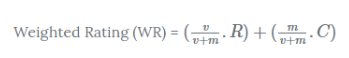
- imdb weight rating
- vote_count(v)가 많으면 많을 수록 1에 가까워질것이고 적어지면 0에 가까워질것이다
- 인기영화는 가중치를 그대로 노출하고, 인기없는 영화는 가중치를 줄인다
- 인기영화가 받는 전체 평점 평균의 영향은 줄이고, 인기있는 영화의 전체 평균에 대한 영향은 늘린다

In [7]:
C = data['vote_average'].mean()
m = data['vote_count'].quantile(0.9)
q_movies = data.copy().loc[data['vote_count']>=m] #상위 10%의 vote를 받은 영화들
q_movies.shape

(481, 23)

In [8]:
def weight_rating(x,m=m,C=C):
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+m)*R) + (m/(m+v)*C)

In [9]:
q_movies['score'] = weight_rating(q_movies)

In [10]:
q_movies = q_movies.sort_values(by='score',ascending=False)
q_movies[['title_x','vote_count','vote_average','score']].head(10)

,title_x,vote_count,vote_average,score
1881,The Shawshank Redemption,8205,8.5,8.059258
662,Fight Club,9413,8.3,7.939256
65,The Dark Knight,12002,8.2,7.920020
3232,Pulp Fiction,8428,8.3,7.904645
96,Inception,13752,8.1,7.863239
3337,The Godfather,5893,8.4,7.851236
95,Interstellar,10867,8.1,7.809479
809,Forrest Gump,7927,8.2,7.803188
329,The Lord of the Rings: The Return of the King,8064,8.1,7.727243
1990,The Empire Strikes Back,5879,8.2,7.697884


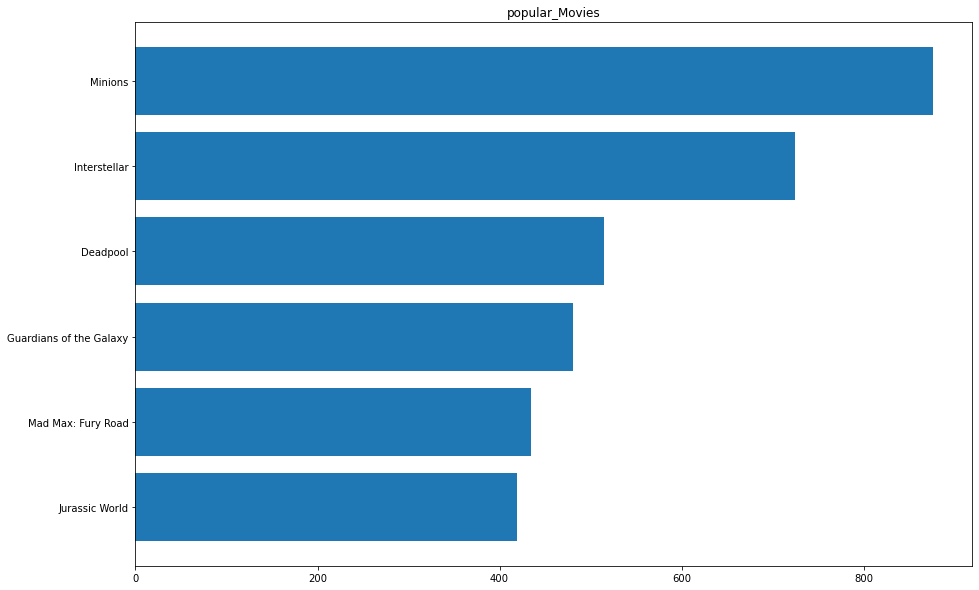

In [11]:
popular = data.sort_values('popularity',ascending=False)
plt.figure(figsize=(15,10))
plt.barh(popular['title_x'].head(6),popular['popularity'].head(6))
plt.gca().invert_yaxis()
plt.title('popular_Movies');

## Content Based Filtering
- item별 유사도를 구하기 위해 cast, crew, keyword, tagline을 사용하고
- cos()으로 유사도를 구하여 추천한다

- overview Vectorize

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words='english') #조사 생략

data['overview'] = data['overview'].fillna('')

tfidf_matrix = tfidf.fit_transform(data['overview']) #out to sparse set

tfidf_matrix

<4803x20978 sparse matrix of type '<class 'numpy.float64'>'
	with 125840 stored elements in Compressed Sparse Row format>

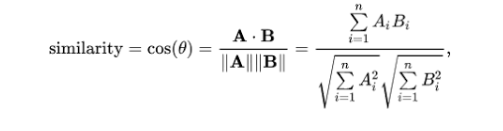
- pearson, cos 등 유사도를 측정할 수 있는 method 지정
- cos = 0 이면 두 변수가 직교하기 때문에 독립(유사X)
- cos = 1 이면 종속이기 때문에 완전 똑같음

In [13]:
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
cosine_sim = linear_kernel(tfidf_matrix,tfidf_matrix)

In [14]:
indices = pd.Series(data.index,index=data['title_x']).drop_duplicates()

In [15]:
#유사도 상위 10개 출력
def get_recommendation(title,cosine_sim=cosine_sim):
    idx = indices[title]
    temp = pd.DataFrame(cosine_sim)[idx].reset_index().rename(columns={0:'sim'})
    temp.columns = ['index','sim']
    movie_indices = list(temp.sort_values(by='sim',ascending=False).iloc[1:10]['index'])
    return data['title_x'].iloc[movie_indices]

In [16]:
get_recommendation('The Dark Knight Rises')

65                              The Dark Knight
299                              Batman Forever
428                              Batman Returns
1359                                     Batman
3854    Batman: The Dark Knight Returns, Part 2
119                               Batman Begins
2507                                  Slow Burn
9            Batman v Superman: Dawn of Justice
1181                                        JFK
Name: title_x, dtype: object

In [17]:
from ast import literal_eval
#str to python object
features = ['cast','crew','keywords','genres']
for feature in features:
    data[feature] = data[feature].apply(literal_eval)

In [18]:
def get_director(x): #행마다 crew 
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [19]:
def get_list(x):
    if isinstance(x,list):
        names = [i['name'] for i in x]
        names = list(set(names))
        if len(names) > 3:
            names = names[:3]
        return names
    return []

In [20]:
data['director'] = data['crew'].apply(get_director)

features = ['cast','keywords','genres']
for feature in features:
    data[feature] = data[feature].apply(get_list)
    

In [21]:
data['homepage'] = data['homepage'].fillna('none')

In [22]:
#homepage에서 middle address 추출
p = re.compile('[^http://www.|^s://www.].*(?=.com)')
lst=[]
for i in range(data.shape[0]):
    lst.append(p.findall(data['homepage'][i]))
data['site'] = pd.DataFrame(lst)[0]
data['site']= data['site'].fillna(' ')

In [24]:
#convert to lower case and trim
#vectorize할 때의 오류를 줄일 수 있다
def clean_data(x):
    if isinstance(x,list):
        return [str.lower(i.replace(' ','')) for i in x]
    else:
        
        if isinstance(x,str):
            return str.lower(x.replace(' ',''))
        
        else:
            return ''

In [43]:
data[['cast','keywords','director','genres']].head()

,cast,keywords,director,genres
0,"[peterdillon, jasonwhyte, chrismala]","[alienplanet, society, future]",jamescameron,"[adventure, fantasy, action]"
1,"[mackenziecrook, davidbailie, tomhollander]","[shipwreck, strongwoman, fighter]",goreverbinski,"[adventure, fantasy, action]"
2,"[victorschefé, georgelasha, francisattakpah]","[spy, basedonnovel, secretagent]",sammendes,"[crime, adventure, action]"
3,"[desmondharrington, cindyjackson, diogohausen]","[vigilante, tragichero, terrorism]",christophernolan,"[crime, thriller, drama]"
4,"[donstark, dominicwest, josephbillingiere]","[steampunk, spacetravel, medallion]",andrewstanton,"[adventure, action, sciencefiction]"


In [26]:
features = ['cast','keywords','director','genres']
for feature in features:
    data[feature] = data[feature].apply(clean_data)

In [36]:
def create_soup(x): #cast keywords genres의 경우 가장 앞의 3개만 뽑히기 때문에 비교불가하여 성능이 떨어질 수도 있다
    return ' '.join(x['keywords']) + ' ' + ' '.join(x['cast']) + ' ' + x['director'] + ' ' + ' '.join(x['genres']) + ' ' + x['site']
data['soup'] = data.apply(create_soup,axis=1)

In [37]:
#soup를 이용한 CountVectorize
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(stop_words='english')

count_matrix = cv.fit_transform(data['soup'])

In [44]:
#keywords, cast, director, genres
cosine_sim2 = cosine_similarity(count_matrix,count_matrix)
indices = pd.Series(data.index,index=data['title_x'])
indices
get_recommendation('The Dark Knight Rises',cosine_sim2)

65                               The Dark Knight
2384                                      Carlos
119                                Batman Begins
4638                    Amidst the Devil's Wings
714                                   Collateral
1051                                   Prisoners
2670                               Broken Horses
3199    Red Riding: In the Year of Our Lord 1974
2507                                   Slow Burn
Name: title_x, dtype: object

## Collaborative Filtering
- contents based filtering에서는 같은 부류의 콘텐츠를 뛰어넘는 참신성있는 추천을 하지 못한다 
- item based CF 열(아이템)을 기준으로 similarity를 계산하는 것 -> 확장성, 희소성 Down
- user based CF 행(유저)을 기준으로 similarity를 계산하는것 -> 장기적으로 유저의 선호가 바뀜

<size > 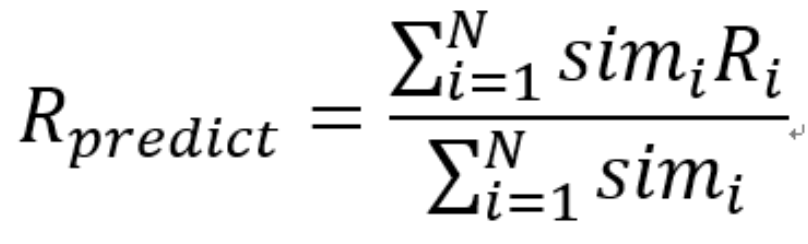
    - 예측값을 구할 때 자기 자신의 similarity 대신 가장 유사한 유저의 점수인 KNN을 쓴다
   

In [155]:
from surprise import Reader,Dataset,SVD
from surprise.model_selection import KFold, cross_validate
from surprise.dataset import DatasetAutoFolds
from sklearn.model_selection import train_test_split
reader = Reader()
ratings = pd.read_csv('ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [165]:
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import KFold

# Load the ratings data into a Surprise Dataset object
ratings = pd.read_csv('ratings.csv')
reader = Reader(rating_scale=(0.5,5))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader=reader)

# Use DatasetAutoFolds to generate folds for cross-validation
kf = KFold(n_splits=5)
data_folds = kf.split(data)

In [179]:
trainset = data.build_full_trainset()
svd.fit(trainset)

In [175]:
svd.predict(4,302,3)

Prediction(uid=4, iid=302, r_ui=3, est=4.087703087383842, details={'was_impossible': False})

In [185]:
'''
for trainset, testset in data_folds:
    trainset = trainset    
    testset = testset
'''

'\nfor trainset, testset in data_folds:\n    trainset = trainset    \n    testset = testset\n'